In [1]:
#importing libraries

import numpy as np
import pandas as pd
import nltk
import re
import json
import seaborn as sns
import mysql.connector as sqlcon
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import seaborn as sns
from PIL import Image

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
%matplotlib inline

In [2]:
#connecting to mysql local server

conn=sqlcon.connect(
    host='localhost',user='danish',
    password='Danish@2020',db='testdb', 
    auth_plugin='mysql_native_password')

cur=conn.cursor(buffered=True)


In [3]:
#Fetching Data from mySQL table

query="SELECT DISTINCT tweet FROM Data"
cur.execute(query)
data = pd.read_sql(query,conn)
data = pd.DataFrame(data['tweet'],columns=['tweet'])
data.tail()

,tweet
5090,RT @RedJohnBounds: The government has lost con...
5091,RT @Drailxthecircus: @eugyppius1 If this does ...
5092,RT @RodneyNCulleton: The PM is pushing for new...
5093,RT @WUSTL: “We’re not done with this wave of t...
5094,@Pink Jesus Christ. Bet you never thought like...


In [99]:
#Data Preprocessing

def rem_extras(text):
    text=text.lower()
    text=re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|([0-9])|rt|repo"," ",text)
    return text

data['tweet'] = data['tweet'].apply(lambda x: rem_extras(x))


stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text=text.split()
    text = [word for word in text if word not in stopword]
    text = [word for word in text if (len(word)>3)]
    text= " ".join(word for word in text)
    return text
    
data['nonstop'] = data['tweet'].apply(lambda x: remove_stopwords(x))
data

,tweet,nonstop
0,welcome to sicap stories over the next ...,welcome sicap stories next days shining light ...
1,thankful to rajasthan cosmo foundation tr...,thankful rajasthan cosmo foundation trust dona...
2,with an aim to spread awareness amongst t...,spread awareness amongst local populace regard...
3,parents amp caregivers have faced uniqu...,parents caregivers faced unique formidable cha...
4,issues advisories on the issues of ment...,issues advisories issues mental health bonded ...
...,...,...
5090,the government has lost control of covid ...,government lost control covid media decided ig...
5091,if this does not make you question the ...,make question narrative told covid paying
5092,the pm is pushing for new laws to keep in...,pushing laws keep information government handl...
5093,we re not done with this wave of the pan...,done wave pandemic ainly going right direction...


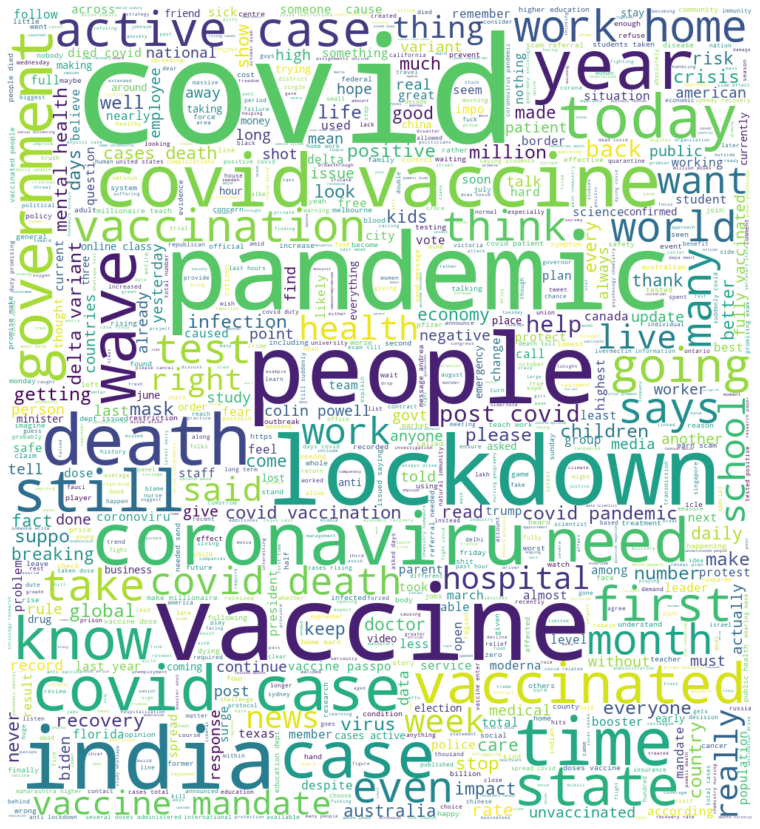

In [100]:
#Generating WordCloud

text = " ".join(words for words in data.nonstop)
Mask = np.array(Image.open('india.png'))
wc = WordCloud(
               mask=Mask, background_color="white",
               max_words=1000, max_font_size=200,
               random_state=42, width=15,
               height=15)
wc.generate(text)
plt.figure(figsize=[15,15])
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.savefig('output/Wordcloud.jpg')
plt.show()

In [101]:
#Text to vector transformation
desc=data['nonstop'].values
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(desc)


In [102]:
#Generating binary arrays

pca = PCA(n_components=2)
df = pca.fit_transform(X.toarray())

In [103]:
def KMClusters(dframe,n_clus, iters):

    #1 Initialize the class object
    kmeans = KMeans(n_clusters= n_clus, n_init=iters)

    #2 predict the labels of clusters.
    label = kmeans.fit_predict(dframe)

    #3 Getting the Centroids
    centroids = kmeans.cluster_centers_
    u_labels = np.unique(label)

    #plotting the results:
    plt.subplots(figsize=(15,8))
    for i in u_labels:
        plt.scatter(dframe[label == i , 0] , dframe[label == i , 1] , label = i)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
    plt.title(str(n_clus) + ' clusters')
    plt.savefig('output/' + str(n_clus) +'clusters.jpg', format="JPG")
    plt.legend()
    plt.show()

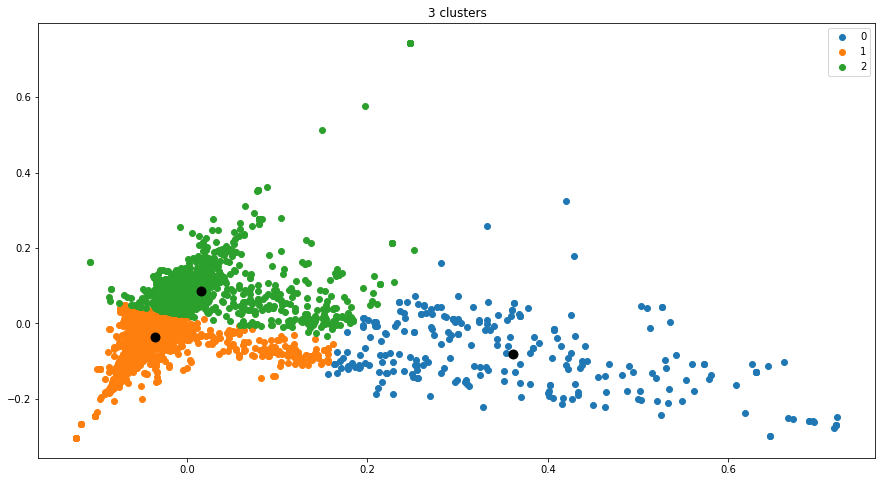

In [104]:

KMClusters(df,3,20)


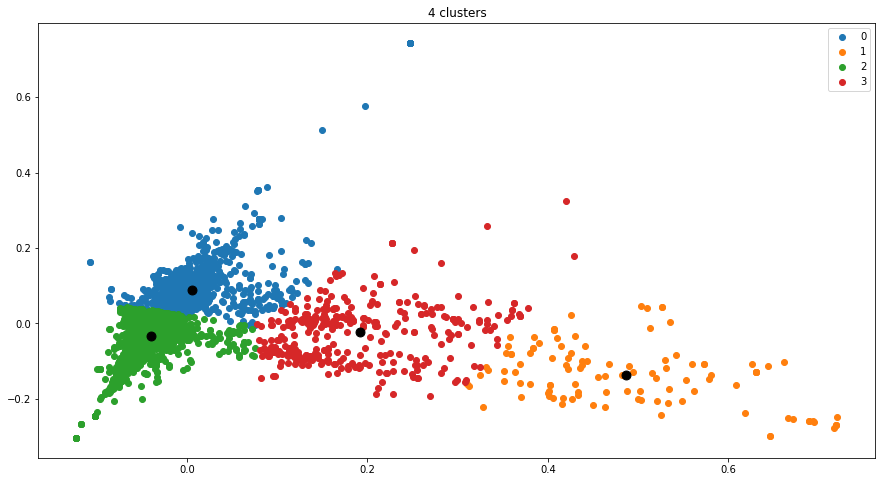

In [105]:
KMClusters(df,4,20)

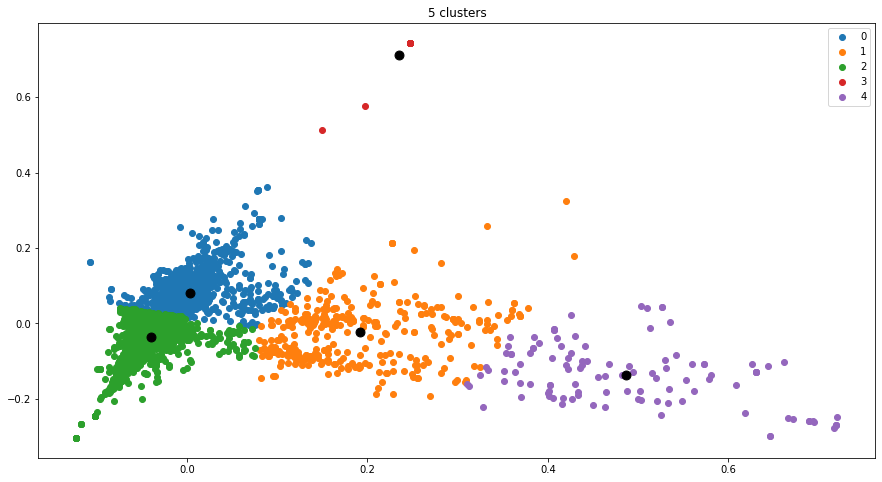

In [106]:
KMClusters(df,5,20)

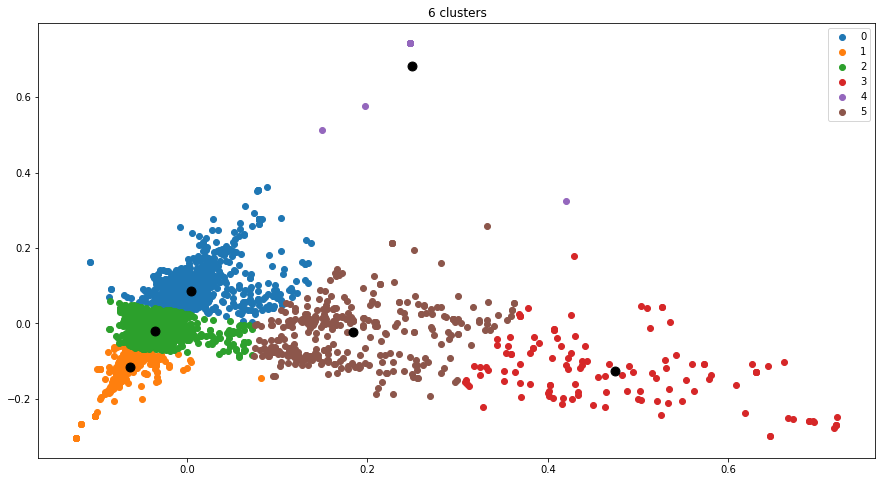

In [107]:
KMClusters(df,6,20)

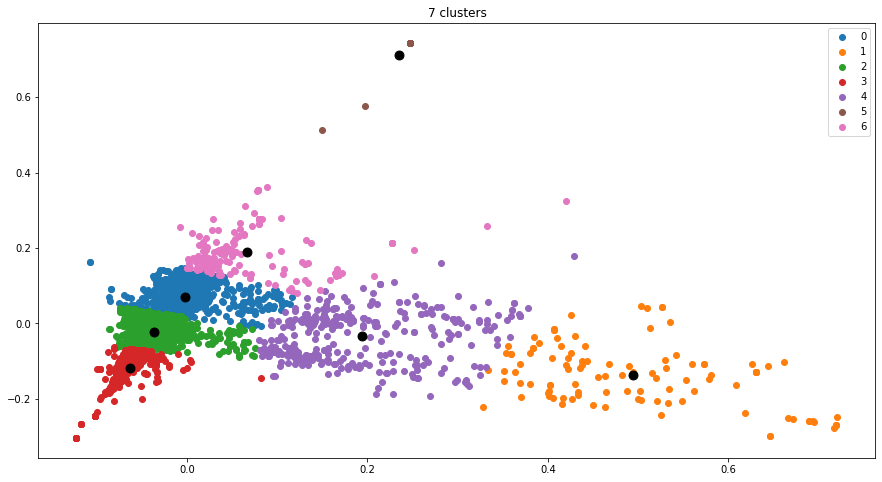

In [108]:
KMClusters(df,7,20)

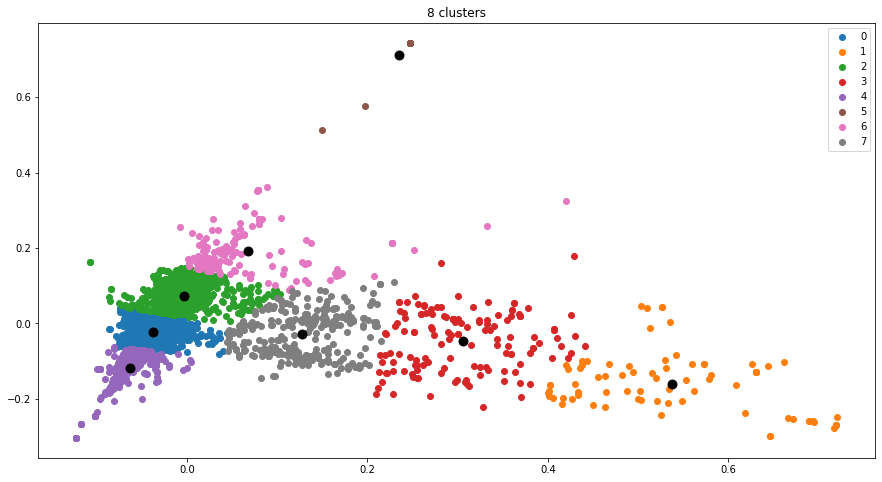

In [109]:
KMClusters(df,8,20)

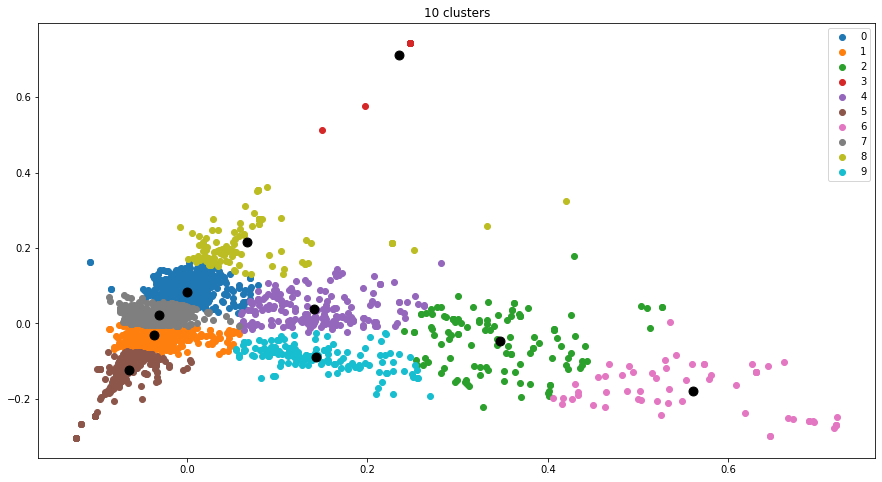

In [110]:
KMClusters(df,10,20)

In [136]:
def optics(X):
    ss = StandardScaler()
    X1 = ss.fit_transform(X)

    db = OPTICS()
    apply=db.fit(X1)
    label=db.fit_predict(X1)
    u_labels=np.unique(label)
    labels=db.labels_
    
    no_clusters = len(np.unique(labels) )
    no_noise = np.sum(np.array(labels) == -1, axis=0)
    
    print('Estimated no. of clusters: %d' % no_clusters)
    print('Estimated no. of noise points: %d' % no_noise)

    # Generate scatter plot
    #colors = list(map(lambda x: '#3b4cc0' if x == 1 else '#b40426', labels))
    plt.subplots(figsize=(10,10))
    #for i in u_labels:
        #plt.scatter(X1[label == i , 0] , X1[label == i , 1] , label = i)
    plt.scatter(X[:,0], X[:,1])
    plt.title(f'OPTICS clustering \n Estimated no. of clusters: %d \n Estimated no. of noise points: %d' %( no_clusters, no_noise ))
    plt.xlabel('Axis X[0]')
    plt.ylabel('Axis X[1]')
    plt.savefig('output/OPTICS_clustering.jpg')
    plt.show()

/home/danish/.local/lib/python3.8/site-packages/sklearn/cluster/_optics.py:803: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]
/home/danish/.local/lib/python3.8/site-packages/sklearn/cluster/_optics.py:803: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Estimated no. of clusters: 300
Estimated no. of noise points: 2704


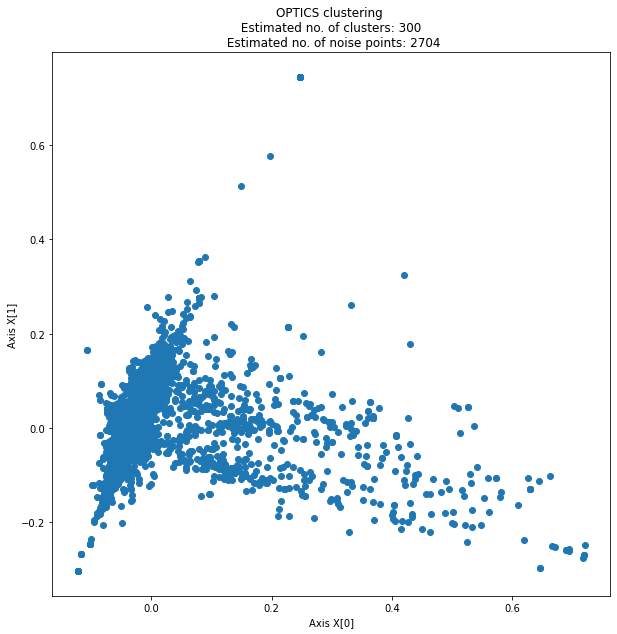

In [137]:
optics(df)

/home/danish/.local/lib/python3.8/site-packages/sklearn/cluster/_optics.py:803: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


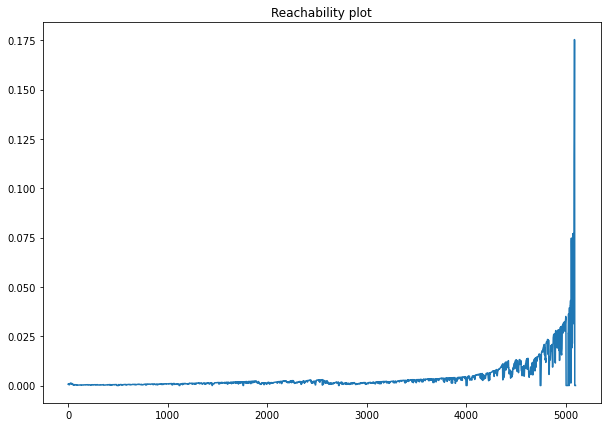

In [115]:
db = OPTICS().fit(df)
reachability = db.reachability_[db.ordering_]
plt.subplots(figsize=(10,7))
plt.plot(reachability)
plt.title('Reachability plot')
plt.savefig('output/Reachability plot.jpg')
plt.show()

In [116]:
clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05)

# Run the fit
clust.fit(df)

labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=0.5)
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=2)

space = np.arange(len(df))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]


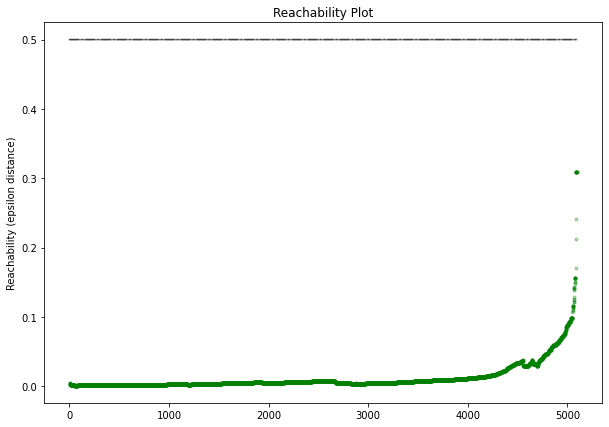

In [117]:
# Reachability plot
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
plt.subplots(figsize=(10,7))
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    plt.plot(Xk, Rk, color, alpha=0.3)
plt.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
plt.plot(space, np.full_like(space, 0.5, dtype=float), 'k-', alpha=0.5)
plt.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
plt.ylabel('Reachability (epsilon distance)')
plt.title('Reachability Plot')
plt.show()

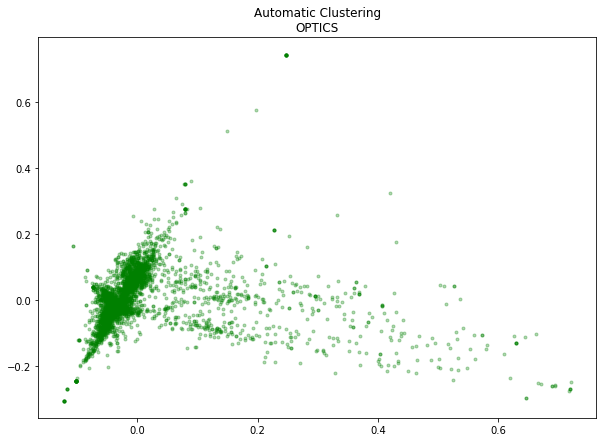

In [140]:
# OPTICS PLOT
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
plt.subplots(figsize=(10,7))
for klass, color in zip(range(0, 5), colors):
    Xk = df[clust.labels_ == klass]
    plt.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
plt.plot(df[clust.labels_ == -1, 0], df[clust.labels_ == -1, 1], 'k+', alpha=0.1)
plt.title('Automatic Clustering\nOPTICS')
plt.savefig('output/OPTICS.jpg')
plt.show()

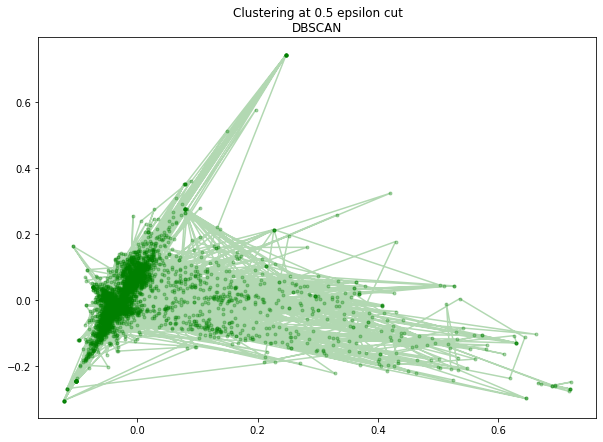

In [119]:
# DBSCAN at 0.5
colors = ['g', 'greenyellow', 'olive', 'r', 'b', 'c']
plt.subplots(figsize=(10,7))
for klass, color in zip(range(0, 6), colors):
    Xk = df[labels_050 == klass]
    plt.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker='.')
plt.plot(df[labels_050 == -1, 0], df[labels_050 == -1, 1], 'k+', alpha=0.1)
plt.title('Clustering at 0.5 epsilon cut\nDBSCAN')
plt.savefig('output/DBSCAN@0.5.jpg')
plt.show()

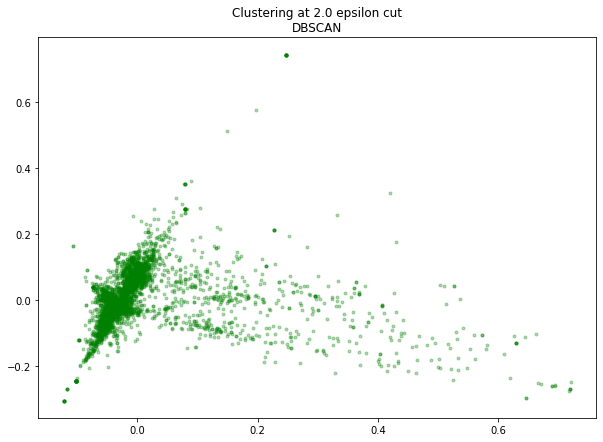

In [120]:
# DBSCAN at 2.
colors = ['g.', 'm.', 'y.', 'c.']
plt.subplots(figsize=(10,7))
for klass, color in zip(range(0, 4), colors):
    Xk = df[labels_200 == klass]
    plt.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
plt.plot(df[labels_200 == -1, 0], df[labels_200 == -1, 1], 'k+', alpha=0.1)
plt.title('Clustering at 2.0 epsilon cut\nDBSCAN')
plt.savefig('output/DBSCAN@2.jpg')
plt.show()